In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import Patch
%matplotlib inline

In [2]:
b1 = pd.read_csv("Data/Bumblebee_data_climate_Marshall_et_al_2020.csv")
b2 = pd.read_csv("Data/Bumblebee_data_Marshall_et_al_2020.csv")
plants = pd.read_csv("Data/Plant_data_Marshall_et_al_2020.csv")
regional_trend = pd.read_csv("Data/Regional_Trend_Temps.csv")
tr = pd.read_csv("Data/Regional_August_Temps_1910_2010.csv")

print(f"Shape Bumblebee data climate (b1) : {b1.shape}")
print(f"Shape Bumblebee data (b2) : {b2.shape}")
print(f"Shape Plant data {plants.shape}")
print(f"Regional trend data {regional_trend.shape}")


Shape Bumblebee data climate (b1) : (854, 11)
Shape Bumblebee data (b2) : (911, 8)
Shape Plant data (1699, 9)
Regional trend data (19293, 8)


In [3]:
# Lire un fichier CSV compressé en Gzip
data_1863_1949 = pd.read_csv("Data/Q_65_1863-1949_RR-T-Vent.csv.gz",sep=';')
data_1950_2023 = pd.read_csv("Data/Q_65_previous-1950-2023_RR-T-Vent.csv.gz",sep=';')

data_1950_2023['AAAAMMJJ'] = pd.to_datetime(data_1950_2023['AAAAMMJJ'], format='%Y%m%d')
data_1863_1949['AAAAMMJJ'] = pd.to_datetime(data_1863_1949['AAAAMMJJ'], format='%Y%m%d')

# Filtrer les entrées où l'année est <= 2010 pour être en accord avec l'article des bourdons 
data_1950_2010 = data_1950_2023[data_1950_2023['AAAAMMJJ'].dt.year <= 2010]

# Concatenation des dataframes de France Meteo pour les années 1863 - 2010
data_FrMeteo_1863_2010 = pd.concat([data_1863_1949, data_1950_2010])
print(f"France Meteo 1863 - 2010 : {data_FrMeteo_1863_2010.shape}")

France Meteo 1863 - 2010 : (990868, 58)


In [4]:
# Elimination colonnes qui ne concernent pas la température

colonnes_elim = [
    'RR',    'QRR', # Quantité de précipitation tombée en 24h 
    'HTN',   'QHTN', # Heure de TN (température minimale sous abri)
    'HTX',   'QHTX', # Heure de TX (température maximale sous abri) 
    'FFM',   'QFFM', # Moyenne quotidienne de la force du vent moyenné sur 10 mn, à 10 m (en m/s et 1/10)
    'FF2M',  'QFF2M', # Moyenne quotidienne de la force du vent moyenné sur 10 mn, à 2 m (en m/s et 1/10)
    'FXY',   'QFXY', # maximum quotidien de la force maximale horaire du vent moyenné sur 10 mn, à 10 m (en m/s et 1/10)
    'DXY',   'QDXY', # direction de FXY
    'HXY',   'QHXY', # heure de FXY (hhmm)
    'FXI',   'QFXI', # maximum quotidien de la force maximale horaire du vent instantané, à 10 m (en m/s et 1/10)
    'DXI',   'QDXI', # direction de FXI (en rose de 360)
    'HXI',   'QHXI', # heure de FXI (hhmm)
    'FXI2',  'QFXI2', # maximum quotidien de la force maximale horaire du vent instantané, à  2 m (en m/s et 1/10)
    'DXI2',  'QDXI2', # direction de FXI2 (en rose de 360)
    'HXI2',  'QHXI2', # heure de FXI2 (hhmm)
    'FXI3S', 'QFXI3S', # maximum quotidien de la force maximale horaire du vent moyenné sur 3 s, à 10 m (en m/s et 1/10)
    'DXI3S', 'QDXI3S', # direction de FXI3S (en rose de 360)
    'HXI3S', 'QHXI3S', # heure de FXI3S (hhmm)
    'DRR',   'QDRR',# durée des précipitations (en mn)
    
    # Les données suivantes traitent sur la température mais on s'intereserra exclusivement 
    # aux temps max, min et moy pour pouvoir s'apprcher au résultat de l'article 
    
    'TAMPLI', 'QTAMPLI', # amplitude thermique quotidienne : écart entre TX et TN quotidiens (TX-TN)
    'TNSOL', 'QTNSOL', #  température quotidienne minimale à 10 cm au-dessus du sol
    'TN50', 'QTN50', # température quotidienne minimale à  50 cm au-dessus du sol 
    'DG', 'QDG' # durée de gel sous abri 
]

data_FrMeteo_1863_2010.drop(columns=colonnes_elim, inplace=True)


In [5]:
# Filtrage par code de qualité 
# Cette opération remplace par NaN (pd.NA) toutes les valeurs le code qualité Q* n’est pas dans [0, 1, 9].
ctrl_qual = [
    'TN', 'QTN',
    'TX', 'QTX', 
    'TM', 'QTM',
    'TNTXM', 'QTNTXM', 
]

valeurs_valides = [0, 1, 9]  # On exclut le code 2 qui correspond aux valeurs "douteuse"

for i in range(0, len(ctrl_qual), 2) :
    data_FrMeteo_1863_2010.loc[~data_FrMeteo_1863_2010[ctrl_qual[i+1]].isin(valeurs_valides), ctrl_qual[i]] = pd.NA


# ### Imputation 
# Liste des colonnes aux quelles on faira une imputation
# On separe les noms des listes en qualités et données
qualite_temp = ['QTN', 'QTX', 'QTM', 'QTNTXM']
colonnes_num = [col for col in data_FrMeteo_1863_2010.columns if col not in qualite_temp]


# Supprimer les colonnes de qualité qui ne nous servent plus 
data_FrMeteo_1863_2010.drop(columns=qualite_temp, inplace=True)


In [6]:
"""
Dim de data France Meteo : (990868, 14)


Valeurs NaN avant filtrage par la qualité Q : 

NUM_POSTE         0
NOM_USUEL         0
LAT               0
LON               0
ALTI              0
AAAAMMJJ          0
TN           380157
QTN          380030
TX           384720
QTX          384410
TM           929950
QTM          929918
TNTXM        388635
QTNTXM       388618
-----------------------------------------------------

Valeurs NaN après filtrage par la qualité Q : 


NUM_POSTE         0
NOM_USUEL         0
LAT               0
LON               0
ALTI              0
AAAAMMJJ          0
TN           380157  # température minimale sous abri
TX           384720  # température maximale sous abri
TM           929950  # moyenne quotidienne des températures horaires sous abri
TNTXM        388635  # moyenne quotidienne (TN+TX)/2


On elimine TM car en proportion, il possède 93,8% de valeurs NaN 
On s'interéssera donc que au données de TN, TX et TNTXM 
"""

data_FrMeteo_1863_2010.drop(columns=['TM'], inplace=True)


In [7]:
"""
Jusqu'a présent on a nettoyé nos données de France Meteo on éliminant les colonnes qui ne nous interessé pas et
en effectuant un filtrage de qualité en fonction du control Q, cependant ces données sont enconre sous la forme d'un registre journalier. 
On veut donc lees transformer pour qu'il ressemblent aux données de l'étude des bourdons, pour cela on fait un groupby pour obtenir les données
par an de chaque poste unique.

"""

data_FrMeteo_1863_2010['year'] = data_FrMeteo_1863_2010['AAAAMMJJ'].dt.year
df_annual = data_FrMeteo_1863_2010.groupby(
['NUM_POSTE', 'NOM_USUEL', 'year'], as_index=False
).agg({
'LAT': 'first',
'LON': 'first',
'ALTI': 'first',
'TN': 'mean',
'TX': 'mean',
'TNTXM': 'mean'
})

df_annual.to_csv('Data/data_France_Meteo_1863_2010_year.csv' , index=False)

In [8]:
df_annual.shape

(3055, 9)

In [9]:
# Liste de toutes les espèces de bourdons

unique_bb1 = b1["Visitor"].unique()
unique_bb2 = b2["Visitor"].unique()
unique_visitors3 = plants["Visitor"].unique()

all_unique_bb = set(unique_bb1) | set(unique_bb2)  
all_unique_bb = list(all_unique_bb)  

print(all_unique_bb)

['Bombus ruderarius', 'Bombus sichelii', 'Bombus sylvarum', 'Bombus quadricolor', 'Bombus monticola', 'Bombus soroeensis', 'Bombus hortorum', 'Bombus rupestris', 'Bombus pascuorum', 'Bombus mesomelas', 'Bombus humilis', 'Bombus terrestris complex', 'Bombus gerstaeckeri', 'Bombus mucidus', 'Bombus wurflenii', 'Bombus sylvestris', 'Bombus bohemicus', 'Bombus pratorum', 'Bombus mendax', 'Bombus lapidarius', 'Bombus pyrenaeus']


In [10]:
# Preparation des datasets de Bourdons pour les différents études 

# Fusionner les datasets
df_combined = pd.concat([b1, b2])

# Convertir la colonne "Date" en format datetime et extraire l'année
df_combined["Date"] = pd.to_datetime(df_combined["Date"], errors="coerce")
df_combined["Year"] = df_combined["Date"].dt.year

plants['Date'] = pd.to_datetime(plants['Date'], errors='coerce')

# Filtrer les données valides (exclure les années NaN)
df_combined = df_combined.dropna(subset=["Year"])

# Identifier les périodes
df_combined["Period"] = df_combined["Year"].apply(lambda x: "Avant" if x < 2000 else "Maintenant")




# Filtrer les données valides (en cas de NaN dans la conversion)
df_valid = df_combined.dropna(subset=['Date', 'MinEle', 'MaxEle'])
plants_valid = plants.dropna(subset=['Date', 'MinEle', 'MaxEle'])
plants_valid['Year'] = plants_valid['Date'].dt.year



/tmp/ipykernel_22500/1743196505.py:7: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_combined["Date"] = pd.to_datetime(df_combined["Date"], errors="coerce")
/tmp/ipykernel_22500/1743196505.py:10: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  plants['Date'] = pd.to_datetime(plants['Date'], errors='coerce')


/tmp/ipykernel_22500/3210515951.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_mean_avant = tr_avant.groupby("Altitude_bin")["value"].mean().reset_index()
/tmp/ipykernel_22500/3210515951.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_mean_apres = tr_apres.groupby("Altitude_bin")["value"].mean().reset_index()


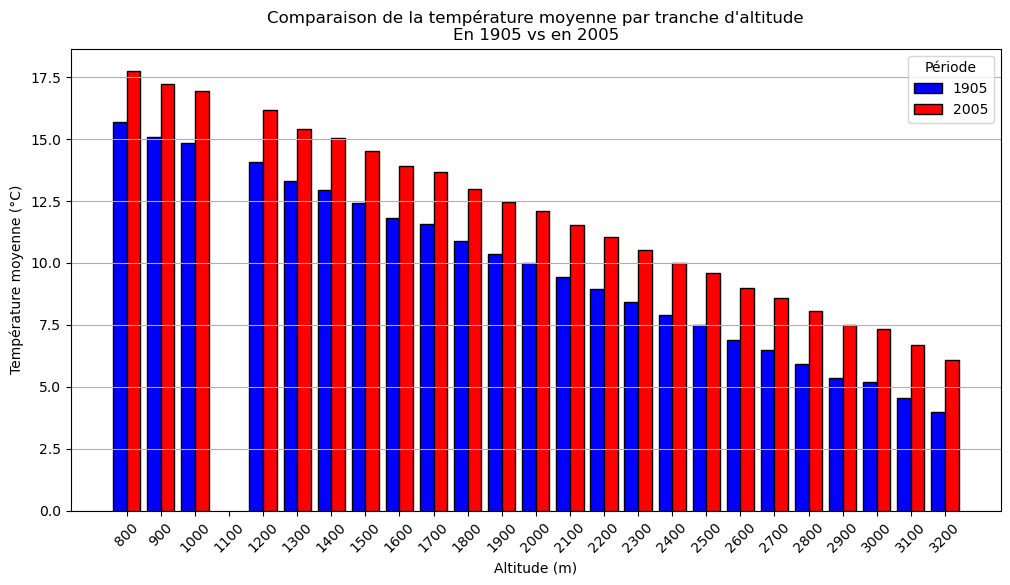

In [11]:
tr = tr[tr["variable"] == "Tave08"].copy()

threshold_year = 2000

tr["Period"] = tr["Year"].apply(lambda x: "Avant" if x < threshold_year else "Maintenant")

tr_avant = tr[tr["Period"] == "Avant"].copy()
tr_apres = tr[tr["Period"] == "Maintenant"].copy()

bins = np.arange(750, 3350, 100)

tr_avant["Altitude_bin"] = pd.cut(tr_avant["Elevation"], bins)
tr_apres["Altitude_bin"] = pd.cut(tr_apres["Elevation"], bins)

temp_mean_avant = tr_avant.groupby("Altitude_bin")["value"].mean().reset_index()
temp_mean_apres = tr_apres.groupby("Altitude_bin")["value"].mean().reset_index()

def bin_midpoint(interval):
    return (interval.left + interval.right) / 2

temp_mean_avant["bin_mid"] = temp_mean_avant["Altitude_bin"].apply(bin_midpoint)
temp_mean_apres["bin_mid"] = temp_mean_apres["Altitude_bin"].apply(bin_midpoint)

merged = pd.merge(
temp_mean_avant, temp_mean_apres, on="Altitude_bin", how="outer", suffixes=("_avant", "_apres")
)
merged = merged.sort_values("bin_mid_avant")
merged["bin_mid"] = merged["bin_mid_avant"].combine_first(merged["bin_mid_apres"]).astype(float)

bar_width = 40
x = merged["bin_mid"]

x_avant = x - bar_width/2
x_apres = x + bar_width/2

plt.figure(figsize=(12, 6))
plt.bar(x_avant, merged["value_avant"], width=bar_width, color="blue", edgecolor="k", label="1905")
plt.bar(x_apres, merged["value_apres"], width=bar_width, color="red", edgecolor="k", label="2005")
plt.xlabel("Altitude (m)")
plt.ylabel("Température moyenne (°C)")
plt.title("Comparaison de la température moyenne par tranche d'altitude\nEn 1905 vs en 2005")
plt.legend(title="Période")
plt.grid(axis="y")
plt.xticks(x, rotation=45)
plt.savefig("plotsBourdons/CompTempMyTranchdAlti")
plt.show()

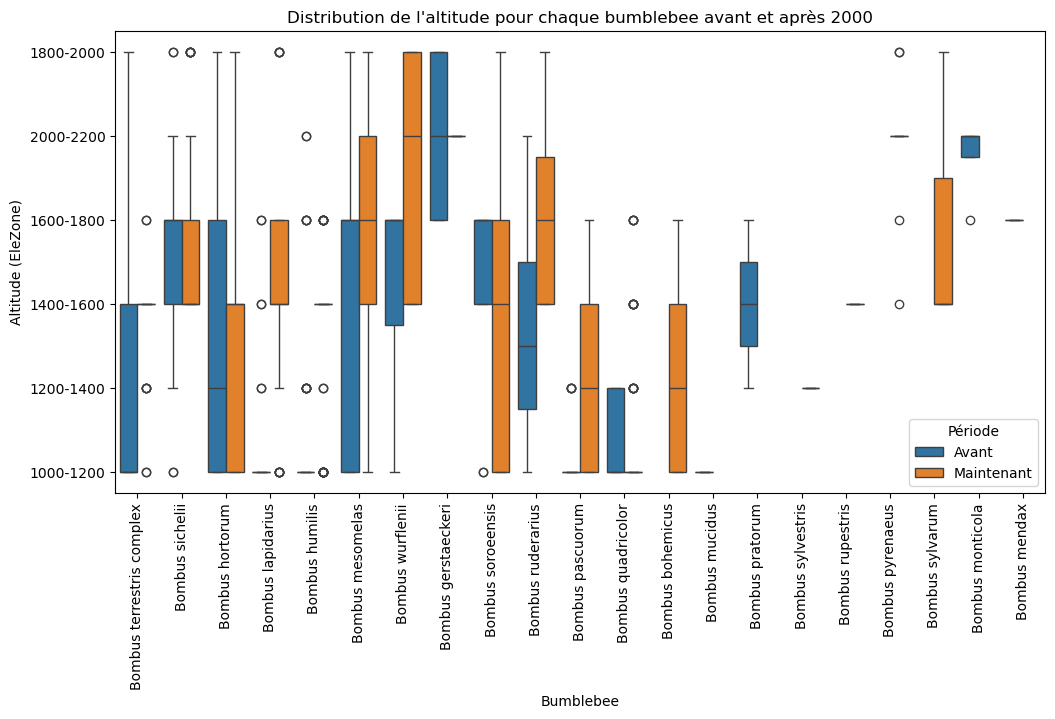

In [12]:
# Tracer le boxplot séparé par période
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_combined, x="Visitor", y="EleZone", hue="Period")

# Personnalisation du graphique
plt.xticks(rotation=90)
plt.xlabel("Bumblebee")
plt.ylabel("Altitude (EleZone)")
plt.title("Distribution de l'altitude pour chaque bumblebee avant et après 2000")
plt.legend(title="Période")
plt.savefig("plotsBourdons/DistribAltBourdonsAvantApres")
plt.show()

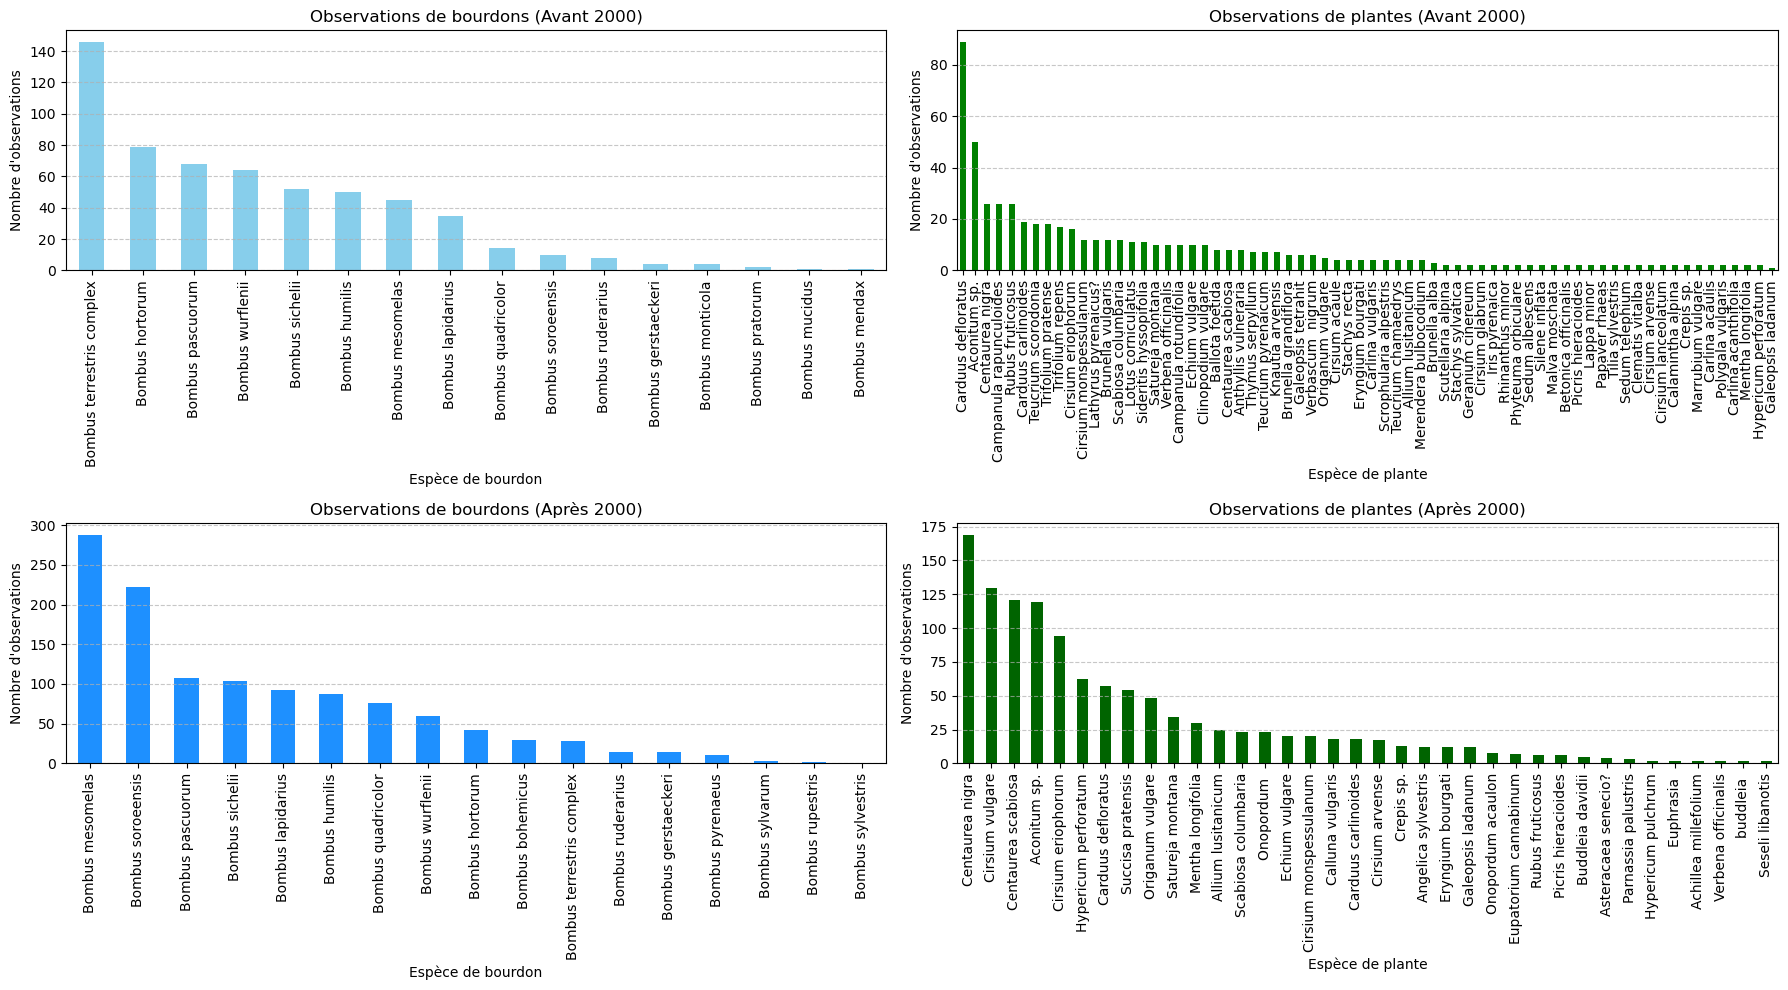

In [13]:
# Séparer les données en deux périodes
df_combined_avant = df_combined[df_combined["Period"] == "Avant"]
df_combined_maintenant = df_combined[df_combined["Period"] == "Maintenant"]

# Compter le nombre d'observations par espèce de bourdon et plante pour chaque période
visitor_counts_avant = df_combined_avant["Visitor"].value_counts()
plant_counts_avant = df_combined_avant["Plant"].value_counts()
visitor_counts_maintenant = df_combined_maintenant["Visitor"].value_counts()
plant_counts_maintenant = df_combined_maintenant["Plant"].value_counts()

# Créer les graphiques côte à côte (Avant vs Maintenant)
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Graphiques pour la période "Avant"
visitor_counts_avant.plot(kind="bar", color="skyblue", ax=axes[0, 0])
axes[0, 0].set_xlabel("Espèce de bourdon")
axes[0, 0].set_ylabel("Nombre d'observations")
axes[0, 0].set_title("Observations de bourdons (Avant 2000)")
axes[0, 0].tick_params(axis="x", rotation=90)
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.7)

plant_counts_avant.plot(kind="bar", color="green", ax=axes[0, 1])
axes[0, 1].set_xlabel("Espèce de plante")
axes[0, 1].set_ylabel("Nombre d'observations")
axes[0, 1].set_title("Observations de plantes (Avant 2000)")
axes[0, 1].tick_params(axis="x", rotation=90)
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

# Graphiques pour la période "Maintenant"
visitor_counts_maintenant.plot(kind="bar", color="dodgerblue", ax=axes[1, 0])
axes[1, 0].set_xlabel("Espèce de bourdon")
axes[1, 0].set_ylabel("Nombre d'observations")
axes[1, 0].set_title("Observations de bourdons (Après 2000)")
axes[1, 0].tick_params(axis="x", rotation=90)
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

plant_counts_maintenant.plot(kind="bar", color="darkgreen", ax=axes[1, 1])
axes[1, 1].set_xlabel("Espèce de plante")
axes[1, 1].set_ylabel("Nombre d'observations")
axes[1, 1].set_title("Observations de plantes (Après 2000)")
axes[1, 1].tick_params(axis="x", rotation=90)
axes[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

# Ajuster la mise en page
plt.tight_layout()
plt.show()

In [14]:
# Compter le nombre d'observations pour chaque combinaison (Visitor, Plant)
preferences = df_combined.groupby(["Visitor", "Plant", "Year"]).size().reset_index(name="Count")

# Trouver la plante la plus visitée pour chaque bourdon
preferred_plants = preferences.loc[preferences.groupby(["Year", "Visitor"])["Count"].idxmax()]

#Séparer les résultats pour l'année 1889 et pour 2005-2006
preferred_plants_1889 = preferred_plants[preferred_plants["Year"] == 1889]
preferred_plants_2005_2006 = preferred_plants[preferred_plants["Year"].isin([2005, 2006])]

preferences_1889 = preferences[preferences["Year"] == 1889]
preferences_2000 = preferences[preferences["Year"].isin([2005, 2006])]
# Afficher le résultat
print("Plantes préférées pour 1889 :")
print(preferred_plants_1889)
print("\nPlantes préférées pour 2005-2006 :")
print(preferred_plants_2005_2006)

Plantes préférées pour 1889 :
                       Visitor                Plant  Year  Count
13         Bombus gerstaeckeri         Aconitum sp.  1889      4
15             Bombus hortorum         Aconitum sp.  1889     28
51              Bombus humilis   Carduus defloratus  1889      8
84           Bombus lapidarius      Centaurea nigra  1889      8
109              Bombus mendax  Teucrium pyrenaicum  1889      1
118           Bombus mesomelas   Carduus defloratus  1889     20
146           Bombus monticola   Carduus defloratus  1889      1
150             Bombus mucidus        Brunella alba  1889      1
191           Bombus pascuorum  Teucrium scorodonia  1889     14
195            Bombus pratorum     Knautia arvensis  1889      1
202         Bombus quadricolor   Carduus defloratus  1889     10
218          Bombus ruderarius        Brunella alba  1889      2
236            Bombus sichelii   Carduus defloratus  1889     16
265          Bombus soroeensis   Carduus defloratus  1889   

In [15]:
preferences_2000 = preferences_2000.sort_values(by=['Visitor', 'Year', 'Count'])
preferences_1889 = preferences_1889.sort_values(by=['Visitor', 'Year', 'Count'])


In [16]:
species_of_interest = ['Bombus humilis', 'Bombus mesomelas', 'Bombus pascuorum',
                       'Bombus quadricolor', 'Bombus ruderarius', 'Bombus sichelii',
                       'Bombus soroeensis', 'Bombus terrestris complex']

df_species = df_combined[df_combined['Visitor'].isin(species_of_interest)]
periods = ['Avant', 'Maintenant']
n_species = len(species_of_interest)

grouped = df_species.groupby(['Visitor', 'Period', 'Plant']).size().reset_index(name='count')

final_dict = {}

for species in species_of_interest:
    final_dict[species] = {}
    for period in periods:
        # On sélectionne les lignes correspondant à l'espèce et à la période
        df_temp = grouped[(grouped['Visitor'] == species) & (grouped['Period'] == period)]
        
        # Si aucune observation n'est disponible pour cette combinaison, on stocke un dict vide
        if df_temp.empty:
            final_dict[species][period] = {}
            continue
        
        # Calcul du total des observations pour cette espèce dans cette période
        total = df_temp['count'].sum()
        
        # On trie par nombre d'observations décroissant
        df_sorted = df_temp.sort_values(by='count', ascending=False)
        
        # On sélectionne les 5 premières plantes
        top3 = df_sorted.head(3)
        
        # On calcule la somme des observations pour les 5 principales plantes
        sum_top3 = top3['count'].sum()
        
        # Construction du dictionnaire pour cette espèce et période
        sub_dict = {}
        for idx, row in top3.iterrows():
            # Proportion : nombre d'observations sur la plante / total des observations
            sub_dict[row['Plant']] = row['count'] / total
        
        # Le reste est regroupé sous la clé "autres"
        sub_dict["autres"] = (total - sum_top3) / total

        # Trier le sous-dictionnaire par ordre alphabétique des clés (les espèces de plantes)
        sorted_sub_dict = dict(sorted(sub_dict.items(), key=lambda item: item[0]))
        
        # Enregistrement dans le dictionnaire final
        final_dict[species][period] = sorted_sub_dict

final_dict


{'Bombus humilis': {'Avant': {'Carduus defloratus': np.float64(0.16),
   'Centaurea nigra': np.float64(0.16),
   'Satureja montana': np.float64(0.08),
   'autres': np.float64(0.6)},
  'Maintenant': {'Centaurea nigra': np.float64(0.13636363636363635),
   'Centaurea scabiosa': np.float64(0.20454545454545456),
   'Satureja montana': np.float64(0.20454545454545456),
   'autres': np.float64(0.45454545454545453)}},
 'Bombus mesomelas': {'Avant': {'Brunella vulgaris': np.float64(0.044444444444444446),
   'Carduus carlinoides': np.float64(0.1111111111111111),
   'Carduus defloratus': np.float64(0.4444444444444444),
   'autres': np.float64(0.4)},
  'Maintenant': {'Aconitum sp.': np.float64(0.11805555555555555),
   'Centaurea scabiosa': np.float64(0.11805555555555555),
   'Cirsium eriophorum': np.float64(0.25),
   'autres': np.float64(0.5138888888888888)}},
 'Bombus pascuorum': {'Avant': {'Clinopodium vulgare': np.float64(0.08823529411764706),
   'Lathyrus pyrenaicus?': np.float64(0.117647058823

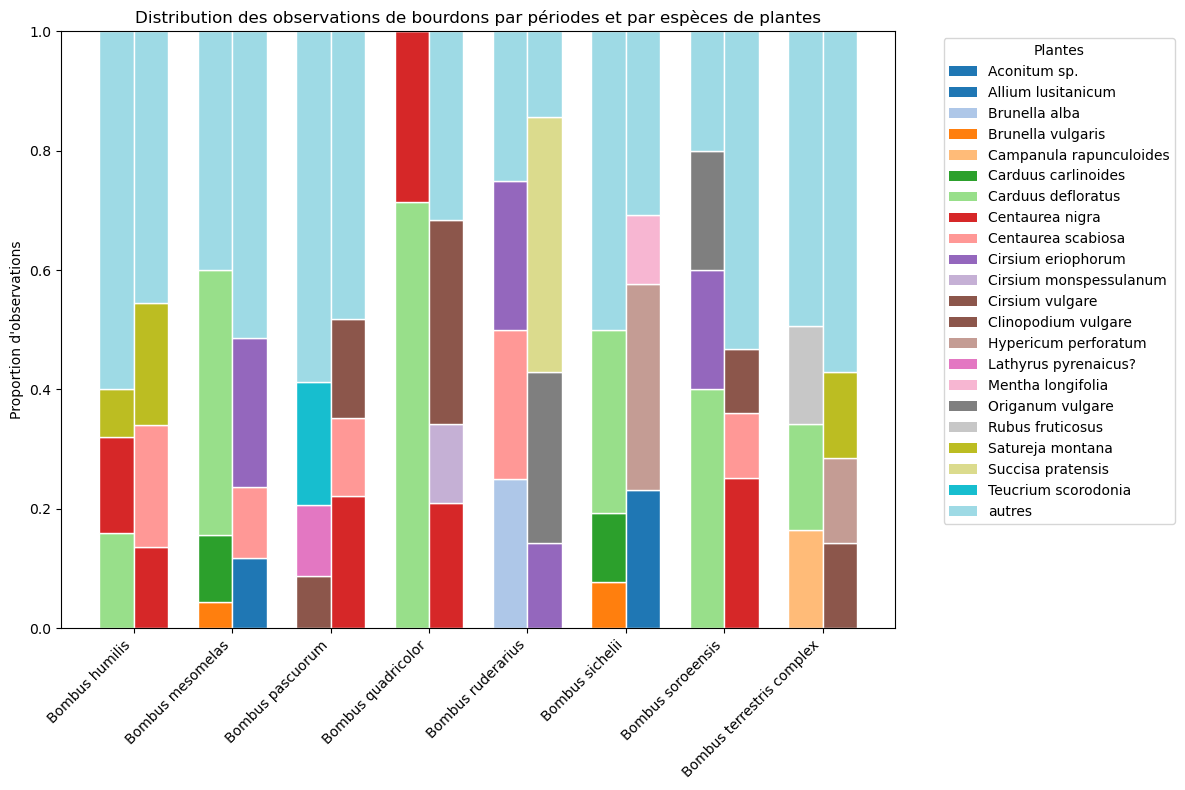

In [17]:
bar_width = 0.35
x = np.arange(n_species)  # positions de base pour les espèces

# Récupérer toutes les catégories présentes dans final_dict
all_categories = set()
for species in species_of_interest:
    for period in periods:
        # On ajoute toutes les clés (catégories) du sous-dictionnaire
        cats = final_dict.get(species, {}).get(period, {}).keys()
        all_categories.update(cats)

# On crée une liste triée (pour garantir un ordre constant dans la légende)
all_categories = list(all_categories)

# Pour garantir que "autres" soit en dernière position dans la légende :
if "autres" in all_categories:
    all_categories.remove("autres")
    all_categories = sorted(all_categories) + ["autres"]
else:
    all_categories = sorted(all_categories)

# On définit une palette de couleurs à partir d'un colormap (ici "tab20")
cmap = plt.get_cmap('tab20')
color_map = {}
for i, cat in enumerate(all_categories):
    color_map[cat] = cmap(i / len(all_categories))

# Création du graphique
fig, ax = plt.subplots(figsize=(12, 8))

# Pour chaque espèce et pour chaque période, on trace la barre empilée
for i, species in enumerate(species_of_interest):
    for j, period in enumerate(periods):
        # On décale la position selon la période : par exemple, pour 2 barres d'un groupe,
        # l'une à gauche et l'autre à droite de la position x[i]
        offset = (-bar_width / 2) if j == 0 else (bar_width / 2)
        xpos = x[i] + offset
        
        # Récupérer notre sous-dictionnaire pour l'espèce et la période actuelle
        sub_dict = final_dict.get(species, {}).get(period, {})
        bottom = 0  # point de départ pour empiler les sections

        # On boucle sur les catégories présentes dans le sous-dictionnaire.
        # On parcourt dans l'ordre d'insertion (les top 5 apparaissant en premier et "autres" en fin)
        for cat, proportion in sub_dict.items():
            # On trace la section de la barre
            ax.bar(
                xpos, proportion, bar_width, bottom=bottom,
                color=color_map[cat],
                edgecolor='white',
            )
            bottom += proportion

ax.set_xticks(x)
ax.set_xticklabels(species_of_interest, rotation=45, ha='right', fontsize=10)
ax.set_ylabel("Proportion d'observations")
ax.set_title("Distribution des observations de bourdons par périodes et par espèces de plantes")



legend_patches = [Patch(facecolor=color_map[cat], label=cat) for cat in all_categories]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', title="Plantes")

plt.tight_layout()
plt.savefig("plotsBourdons/BarresEvolDistribObsBourdons")
plt.show()


In [18]:
pref1889 = preferred_plants_1889[['Visitor', 'Plant']]
pref2005_2006 = preferred_plants_2005_2006[['Visitor', 'Plant']]

pref1889 = pref1889.rename(columns={'Plant': 'Plant_1889'})
pref2005_2006 = pref2005_2006.rename(columns={'Plant': 'Plant_2005_2006'})

merged = pd.merge(pref1889, pref2005_2006, on='Visitor', how='inner')

changes = merged[merged['Plant_1889'] != merged['Plant_2005_2006']]

print("Les espèces de bourdons ayant changé de plante préférée entre 1889 et 2005/2006 :")
changes['Visitor'].unique()

Les espèces de bourdons ayant changé de plante préférée entre 1889 et 2005/2006 :


array(['Bombus humilis', 'Bombus mesomelas', 'Bombus pascuorum',
       'Bombus quadricolor', 'Bombus ruderarius', 'Bombus sichelii',
       'Bombus soroeensis', 'Bombus terrestris complex'], dtype=object)

In [19]:
target_visitors = [ 'Bombus humilis', 'Bombus mesomelas', 'Bombus pascuorum',
                   'Bombus quadricolor', 'Bombus ruderarius', 'Bombus sichelii',
                   'Bombus soroeensis', 'Bombus terrestris complex']

df_target = df_combined[df_combined['Visitor'].isin(target_visitors)].copy()

# Comptage des observations par Visitor, Plant et Period
obs_plant = df_target.groupby(["Visitor", "Plant", "Period"]).size().reset_index(name="PlantCount")

# Comptage total des observations par Visitor et Period (toutes plantes confondues)
obs_total = df_target.groupby(["Visitor", "Period"]).size().reset_index(name="TotalCount")

# Fusionner les deux DataFrames sur Visitor et Period
df_prop = pd.merge(obs_plant, obs_total, on=["Visitor", "Period"], how="left")

# Calcul de la proportion
df_prop["Proportion"] = df_prop["PlantCount"] / df_prop["TotalCount"]


df_prop = df_prop.sort_values(by=["Visitor", "Period", "Proportion"], ascending=[True, True, True])

print("Proportions des observations pour chaque bourdon et chaque plante, selon les périodes:")
list_prop = df_prop["Proportion"].unique()
list_prop.sort()
list_prop


Proportions des observations pour chaque bourdon et chaque plante, selon les périodes:


array([0.00694444, 0.00900901, 0.01369863, 0.01388889, 0.01801802,
       0.01851852, 0.01923077, 0.02083333, 0.02272727, 0.02631579,
       0.02702703, 0.02739726, 0.02941176, 0.03603604, 0.03703704,
       0.03846154, 0.04      , 0.04109589, 0.04166667, 0.04444444,
       0.04504505, 0.04545455, 0.05263158, 0.05479452, 0.05555556,
       0.05769231, 0.05882353, 0.06849315, 0.06944444, 0.07142857,
       0.07407407, 0.07638889, 0.07692308, 0.08      , 0.08333333,
       0.08823529, 0.09090909, 0.0990991 , 0.10810811, 0.11111111,
       0.11363636, 0.11538462, 0.11764706, 0.11805556, 0.12962963,
       0.13157895, 0.13636364, 0.14285714, 0.16      , 0.16438356,
       0.16666667, 0.17808219, 0.2       , 0.20454545, 0.20588235,
       0.21052632, 0.22222222, 0.23076923, 0.25      , 0.25225225,
       0.28571429, 0.30769231, 0.34210526, 0.34615385, 0.4       ,
       0.42857143, 0.44444444, 0.71428571])

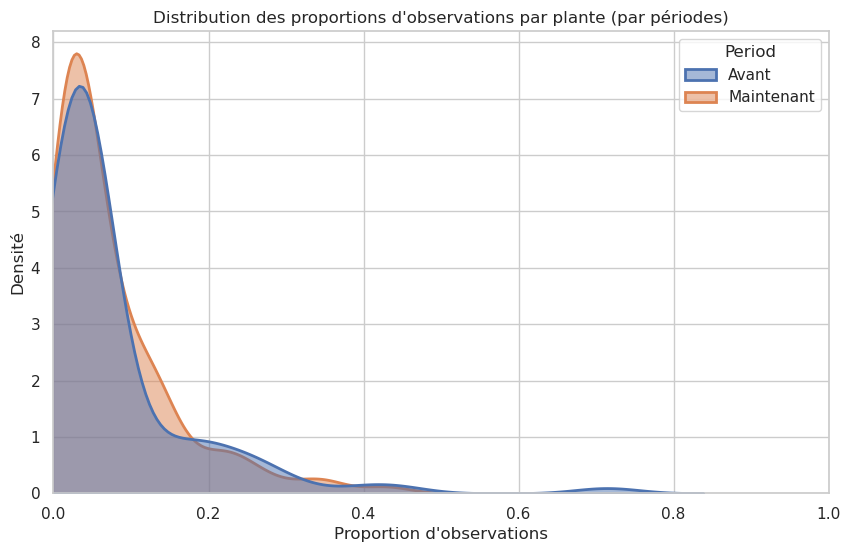

In [20]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.kdeplot(
data=df_prop,
x="Proportion",
hue="Period", # séparation par période
fill=True, # remplissage sous la courbe
common_norm=False, # ne pas normaliser pour chaque groupe séparément
alpha=0.5,
linewidth=2
)

plt.title("Distribution des proportions d'observations par plante (par périodes)")
plt.xlabel("Proportion d'observations")
plt.ylabel("Densité")
plt.xlim(0,1) # comme il s'agit de proportions, les valeurs varient entre 0 et 1

plt.show()

In [25]:
plants_valid

,Visitor,Plant,Family,Date,Site,Data,MinEle,MaxEle,EleZone,Year
0,Bombus quadricolor,Echium vulgare,Hymenoptera,2005-08-24,P190,Survey2005-06,1000,1000,1000-1200,2005
1,Bombus humilis,Echium vulgare,Hymenoptera,2005-08-24,P190,Survey2005-06,1000,1000,1000-1200,2005
2,Bombus humilis,Echium vulgare,Hymenoptera,2005-08-24,P190,Survey2005-06,1000,1000,1000-1200,2005
3,Bombus humilis,Echium vulgare,Hymenoptera,2005-08-24,P190,Survey2005-06,1000,1000,1000-1200,2005
4,Bombus humilis,Echium vulgare,Hymenoptera,2005-08-24,P190,Survey2005-06,1000,1000,1000-1200,2005
...,...,...,...,...,...,...,...,...,...,...
1694,Bombus mesomelas,Cirsium eriophorum,NaN,2006-08-27,P360,Survey2005-06,2150,2150,2000-2200,2006
1695,Bombus soroeensis,Cirsium eriophorum,NaN,2006-08-27,P360,Survey2005-06,2150,2150,2000-2200,2006
1696,Bombus mesomelas,Cirsium eriophorum,NaN,2006-08-27,P360,Survey2005-06,2150,2150,2000-2200,2006
1697,Bombus mesomelas,Cirsium eriophorum,NaN,2006-08-27,P360,Survey2005-06,2150,2150,2000-2200,2006


plants_valid

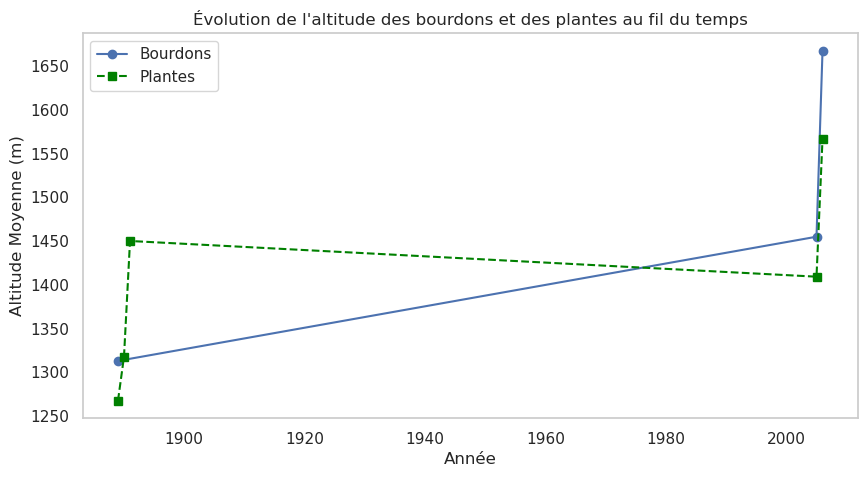

In [28]:

# Calculer l'altitude moyenne
df_valid['MeanEle'] = (df_valid['MinEle'] + df_valid['MaxEle']) / 2
plants_valid['MeanEle'] = (plants_valid['MinEle'] + plants_valid['MaxEle']) / 2

# Grouper par année pour une meilleure visualisation
df_grouped = df_valid.groupby('Year')['MeanEle'].mean()
plants_grouped = plants_valid.groupby('Year')['MeanEle'].mean()

# Tracer le graphique
plt.figure(figsize=(10, 5))
plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-', label='Bourdons')
plt.plot(plants_grouped.index, plants_grouped.values, marker='s', linestyle='--', label='Plantes', color='green')
plt.xlabel('Année')
plt.ylabel('Altitude Moyenne (m)')
plt.title("Évolution de l'altitude des bourdons et des plantes au fil du temps")
plt.legend()
plt.grid()

plt.show()


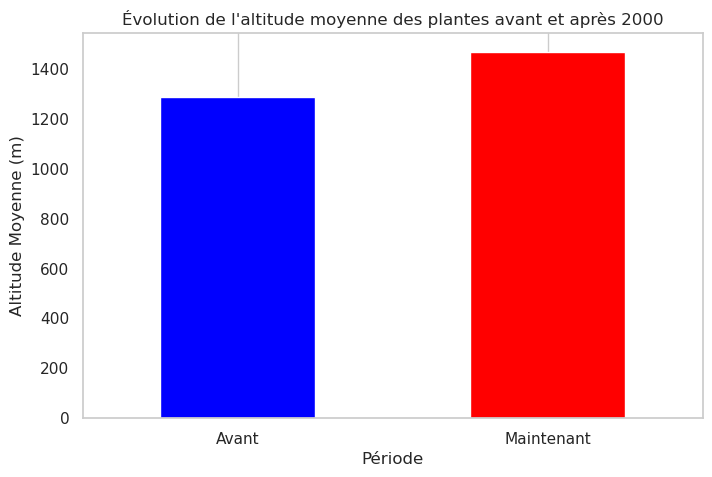

In [30]:
# Calculer la moyenne générale de l'altitude pour chaque période
mean_altitude_by_period = plants_valid.groupby('Period')['MeanEle'].mean()

# Tracer un graphique en barres
mean_altitude_by_period.plot(kind='bar', figsize=(8, 5), color=['blue', 'red'])

# Personnalisation du graphique
plt.xlabel('Période')
plt.ylabel('Altitude Moyenne (m)')
plt.title("Évolution de l'altitude moyenne des plantes avant et après 2000")
plt.xticks(rotation=0)
plt.grid(axis='y')

# Affichage
plt.show()

Attention : Ces plantes préférées ne sont pas dans les données d'altitude pour 1889 : {'Knautia arvensis', 'Brunella alba', 'Teucrium pyrenaicum', 'Teucrium scorodonia', 'Succisa pratensis'}


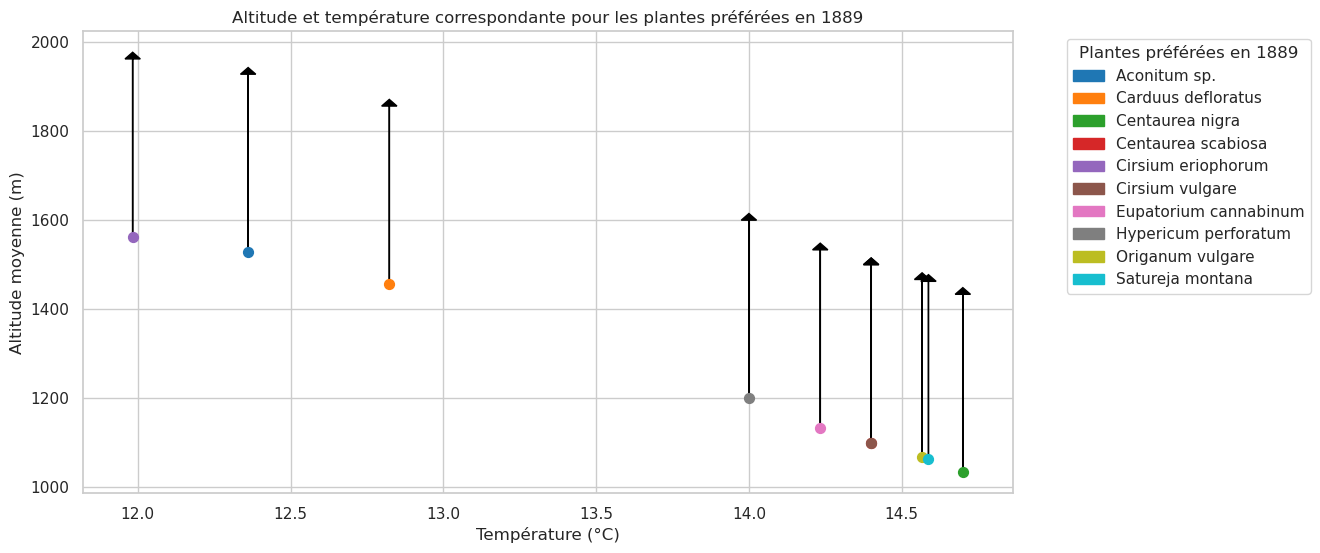

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.patches import Patch

# Charger les données des plantes
df_plants = pd.read_csv("Data/Plant_data_Marshall_et_al_2020.csv")
df_plants["Date"] = pd.to_datetime(df_plants["Date"], dayfirst=True)
df_plants["Year"] = df_plants["Date"].dt.year
df_plants["MeanEle"] = (df_plants["MinEle"].astype(float) + df_plants["MaxEle"].astype(float)) / 2
df_plants["Period"] = df_plants["Year"].apply(lambda x: "Avant" if x < 2000 else "Maintenant")

# Filtrer uniquement les données de 1889
df_plants = df_plants[df_plants["Year"] == 1889]

# Grouper par plante pour obtenir l'altitude moyenne
grouped = df_plants.groupby(["Plant"])["MeanEle"].mean().reset_index()

# Charger les données de température
df_temp = pd.read_csv("Data/Regional_August_Temps_1910_2010.csv")
df_temp = df_temp[df_temp["variable"] == "Tave08"].copy()
df_temp["Elev_round"] = df_temp["Elevation"].round(-1)

# Filtrer uniquement les températures avant 2000
temp_avant = df_temp[df_temp["Year"] < 2000].groupby("Elev_round")["value"].mean().reset_index().sort_values("Elev_round")

# Fonction d'interpolation pour la période "Avant"
f_interp_avant = interp1d(temp_avant["Elev_round"], temp_avant["value"], fill_value="extrapolate")

# Ajouter la température interpolée aux plantes
grouped["Temp"] = grouped["MeanEle"].apply(lambda x: f_interp_avant(x))

# EXTRAIRE LES PLANTES PRÉFÉRÉES
preferred_plant_list = preferred_plants["Plant"].unique()  # Liste des plantes préférées
grouped = grouped[grouped["Plant"].isin(preferred_plant_list)]  # Filtrer les plantes

# Vérifier si des plantes préférées ne sont pas dans grouped
missing_plants = set(preferred_plant_list) - set(grouped["Plant"])
if missing_plants:
    print(f"Attention : Ces plantes préférées ne sont pas dans les données d'altitude pour 1889 : {missing_plants}")

# Créer une figure
plt.figure(figsize=(12, 6))

# Générer une couleur unique pour chaque plante préférée
plants = grouped["Plant"].unique()
colors = {plant: plt.cm.tab10(i % 10) for i, plant in enumerate(plants)}

# Tracer les points uniquement pour 1889
for idx, row in grouped.iterrows():

    plt.scatter(row["Temp"], row["MeanEle"], color=colors[row["Plant"]], marker="o", s=50, zorder=3)
    plt.arrow(row["Temp"], row["MeanEle"], 0, 400, head_width=0.05, head_length=15, fc="black", ec="black")


# Ajouter une légende des plantes (couleur)
patches_plants = [Patch(color=colors[plant], label=plant) for plant in plants]

# Afficher la légende
plt.legend(handles=patches_plants, title="Plantes préférées en 1889", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ajouter les labels et le titre
plt.xlabel("Température (°C)")
plt.ylabel("Altitude moyenne (m)")
plt.title("Altitude et température correspondante pour les plantes préférées en 1889")

plt.grid(True, axis="y")
plt.savefig("plotsBourdons/AltiTempPlantPrefVerticale")
# Afficher le graphique
plt.show()

Attention : Ces plantes préférées ne sont pas dans les données d'altitude pour 1889 : {'Knautia arvensis', 'Brunella alba', 'Teucrium pyrenaicum', 'Teucrium scorodonia', 'Succisa pratensis'}


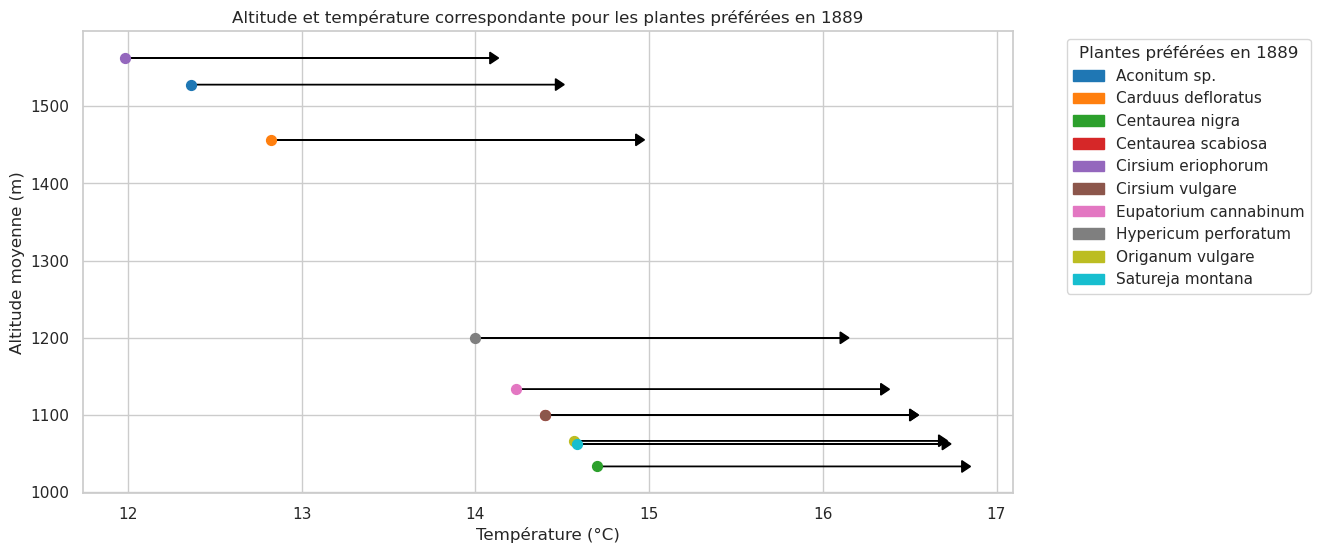

In [32]:
from scipy.interpolate import interp1d
from matplotlib.patches import Patch

# Charger les données des plantes
df_plants = pd.read_csv("Data/Plant_data_Marshall_et_al_2020.csv")
df_plants["Date"] = pd.to_datetime(df_plants["Date"], dayfirst=True)
df_plants["Year"] = df_plants["Date"].dt.year
df_plants["MeanEle"] = (df_plants["MinEle"].astype(float) + df_plants["MaxEle"].astype(float)) / 2
df_plants["Period"] = df_plants["Year"].apply(lambda x: "Avant" if x < 2000 else "Maintenant")

# Filtrer uniquement les données de 1889
df_plants = df_plants[df_plants["Year"] == 1889]

# Grouper par plante pour obtenir l'altitude moyenne
grouped = df_plants.groupby(["Plant"])["MeanEle"].mean().reset_index()

# Charger les données de température
df_temp = pd.read_csv("Data/Regional_August_Temps_1910_2010.csv")
df_temp = df_temp[df_temp["variable"] == "Tave08"].copy()
df_temp["Elev_round"] = df_temp["Elevation"].round(-1)

# Filtrer uniquement les températures avant 2000
temp_avant = df_temp[df_temp["Year"] < 2000].groupby("Elev_round")["value"].mean().reset_index().sort_values("Elev_round")

# Fonction d'interpolation pour la période "Avant"
f_interp_avant = interp1d(temp_avant["Elev_round"], temp_avant["value"], fill_value="extrapolate")

# Ajouter la température interpolée aux plantes
grouped["Temp"] = grouped["MeanEle"].apply(lambda x: f_interp_avant(x))

# EXTRAIRE LES PLANTES PRÉFÉRÉES
preferred_plant_list = preferred_plants["Plant"].unique()  # Liste des plantes préférées
grouped = grouped[grouped["Plant"].isin(preferred_plant_list)]  # Filtrer les plantes

# Vérifier si des plantes préférées ne sont pas dans grouped
missing_plants = set(preferred_plant_list) - set(grouped["Plant"])
if missing_plants:
    print(f"Attention : Ces plantes préférées ne sont pas dans les données d'altitude pour 1889 : {missing_plants}")

# Créer une figure
plt.figure(figsize=(12, 6))

# Générer une couleur unique pour chaque plante préférée
plants = grouped["Plant"].unique()
colors = {plant: plt.cm.tab10(i % 10) for i, plant in enumerate(plants)}

# Tracer les points uniquement pour 1889
for idx, row in grouped.iterrows():

    plt.scatter(row["Temp"], row["MeanEle"], color=colors[row["Plant"]], marker="o", s=50, zorder=3)
    plt.arrow(row["Temp"], row["MeanEle"], 2.1, 0, head_width=15, head_length=0.05, fc="black", ec="black")


# Ajouter une légende des plantes (couleur)
patches_plants = [Patch(color=colors[plant], label=plant) for plant in plants]

# Afficher la légende
plt.legend(handles=patches_plants, title="Plantes préférées en 1889", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ajouter les labels et le titre
plt.xlabel("Température (°C)")
plt.ylabel("Altitude moyenne (m)")
plt.title("Altitude et température correspondante pour les plantes préférées en 1889")

plt.grid(True, axis="y")
plt.savefig("plotsBourdons/AltiTempPlantPrefHorizontale")
# Afficher le graphique
plt.show()

Attention : Ces plantes préférées ne sont pas dans les données d'altitude : {'Knautia arvensis', 'Brunella alba', 'Teucrium pyrenaicum', 'Teucrium scorodonia', 'Succisa pratensis'}


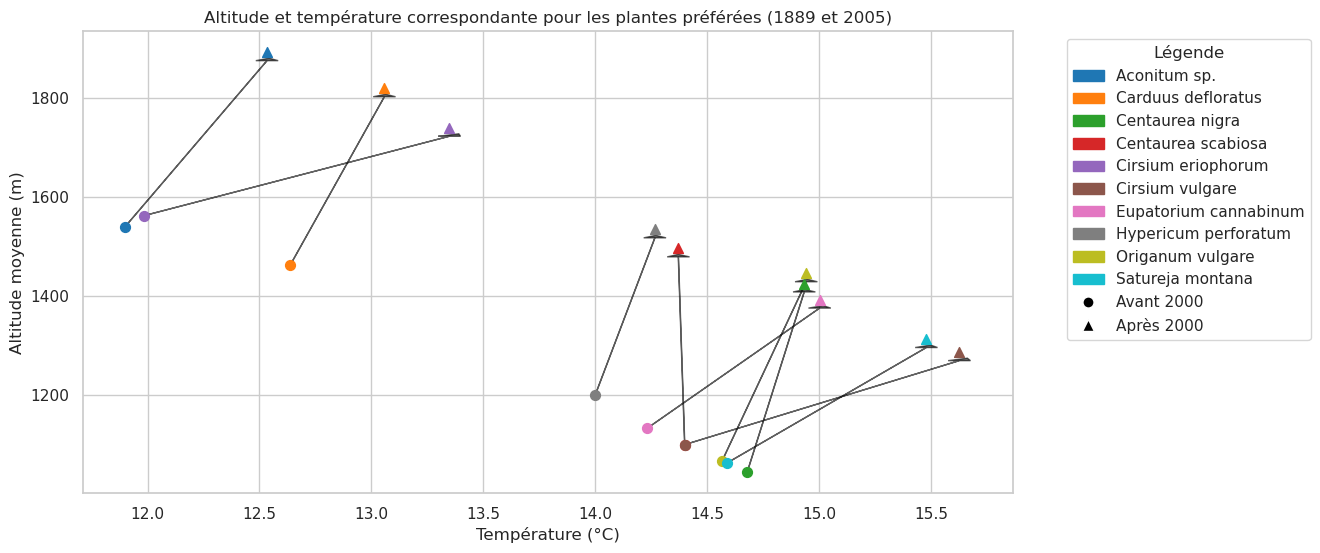

In [33]:
# Charger les données des plantes
df_plants = pd.read_csv("Data/Plant_data_Marshall_et_al_2020.csv")
df_plants["Date"] = pd.to_datetime(df_plants["Date"], dayfirst=True)
df_plants["Year"] = df_plants["Date"].dt.year
df_plants["MeanEle"] = (df_plants["MinEle"].astype(float) + df_plants["MaxEle"].astype(float)) / 2
df_plants["Period"] = df_plants["Year"].apply(lambda x: "Avant" if x < 2000 else "Maintenant")

# Grouper pour obtenir l'altitude moyenne par plante et période
grouped = df_plants.groupby(["Plant", "Period"])["MeanEle"].mean().reset_index()

# Charger les données de température
df_temp = pd.read_csv("Data/Regional_August_Temps_1910_2010.csv")
df_temp = df_temp[df_temp["variable"] == "Tave08"].copy()
df_temp["Elev_round"] = df_temp["Elevation"].round(-1)

temp_avant = df_temp[df_temp["Year"] < 2000].groupby("Elev_round")["value"].mean().reset_index().sort_values("Elev_round")
temp_maintenant = df_temp[df_temp["Year"] >= 2000].groupby("Elev_round")["value"].mean().reset_index().sort_values("Elev_round")

f_interp_avant = interp1d(temp_avant["Elev_round"], temp_avant["value"], fill_value="extrapolate")
f_interp_maintenant = interp1d(temp_maintenant["Elev_round"], temp_maintenant["value"], fill_value="extrapolate")

grouped["Temp"] = grouped.apply(
    lambda row: f_interp_avant(row["MeanEle"]) if row["Period"] == "Avant" else f_interp_maintenant(row["MeanEle"]),
    axis=1
)

# EXTRAIRE LES PLANTES PRÉFÉRÉES
preferred_plant_list = preferred_plants["Plant"].unique()  # Liste des plantes préférées
grouped = grouped[grouped["Plant"].isin(preferred_plant_list)]  # Filtrer les plantes

# Vérifier si des plantes préférées ne sont pas dans grouped
missing_plants = set(preferred_plant_list) - set(grouped["Plant"])
if missing_plants:
    print(f"Attention : Ces plantes préférées ne sont pas dans les données d'altitude : {missing_plants}")

# Créer une figure
plt.figure(figsize=(12, 6))

# Générer une couleur unique pour chaque plante préférée
plants = grouped["Plant"].unique()
colors = {plant: plt.cm.tab10(i % 10) for i, plant in enumerate(plants)}

# Définir les formes pour chaque période
markers = {"Avant": "o", "Maintenant": "^"}

# Tracer les points (NE PAS MODIFIER CE FOR)
for idx, row in grouped.iterrows():
    plt.scatter(row["Temp"], row["MeanEle"], 
                color=colors[row["Plant"]], 
                marker=markers[row["Period"]], 
                s=50, zorder=3)

# Ajouter les flèches entre "Avant" et "Maintenant"
for plant in plants:
    data = grouped[grouped["Plant"] == plant]  # Filtrer par plante
    
    if len(data) == 2:  # Vérifier que la plante a bien les deux périodes
        before = data[data["Period"] == "Avant"]
        after = data[data["Period"] == "Maintenant"]

        if not before.empty and not after.empty:
            x1, y1 = before["Temp"].values[0], before["MeanEle"].values[0]
            x2, y2 = after["Temp"].values[0], after["MeanEle"].values[0]

            # Tracer une flèche reliant les points
            plt.arrow(x1, y1, x2 - x1 , y2 - y1 - 17, 
                      head_width=0.1, head_length=5, fc="black", ec="black", alpha=0.6)

# Ajouter une légende des plantes (couleur)
patches_plants = [Patch(color=colors[plant], label=plant) for plant in plants]

# Ajouter une légende pour les formes (périodes)
patches_periods = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=8, label="Avant 2000"),
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="black", markersize=8, label="Après 2000")
]

# Afficher les légendes
plt.legend(handles=patches_plants + patches_periods, title="Légende", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ajouter les labels et le titre
plt.xlabel("Température (°C)")
plt.ylabel("Altitude moyenne (m)")
plt.title("Altitude et température correspondante pour les plantes préférées (1889 et 2005)")
plt.grid(True, axis="y")
plt.savefig("plotsBourdons/AltiTempPlantPrefReelles")
# Afficher le graphique
plt.show()

Attention : Ces plantes préférées ne sont pas dans les données d'altitude : {'Knautia arvensis', 'Brunella alba', 'Teucrium pyrenaicum', 'Teucrium scorodonia', 'Succisa pratensis'}


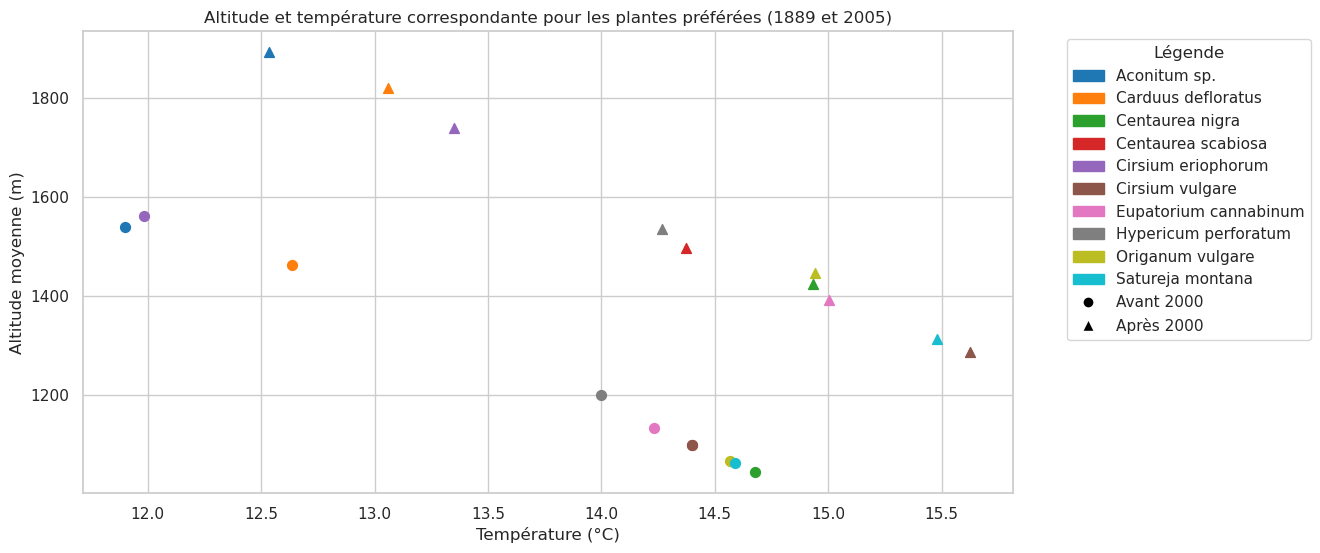

In [34]:
# Charger les données des plantes
df_plants = pd.read_csv("Data/Plant_data_Marshall_et_al_2020.csv")
df_plants["Date"] = pd.to_datetime(df_plants["Date"], dayfirst=True)
df_plants["Year"] = df_plants["Date"].dt.year
df_plants["MeanEle"] = (df_plants["MinEle"].astype(float) + df_plants["MaxEle"].astype(float)) / 2
df_plants["Period"] = df_plants["Year"].apply(lambda x: "Avant" if x < 2000 else "Maintenant")
grouped = df_plants.groupby(["Plant", "Period"])["MeanEle"].mean().reset_index()

# Charger les données de température
df_temp = pd.read_csv("Data/Regional_August_Temps_1910_2010.csv")
df_temp = df_temp[df_temp["variable"] == "Tave08"].copy()
df_temp["Elev_round"] = df_temp["Elevation"].round(-1)

temp_avant = df_temp[df_temp["Year"] < 2000].groupby("Elev_round")["value"].mean().reset_index().sort_values("Elev_round")
temp_maintenant = df_temp[df_temp["Year"] >= 2000].groupby("Elev_round")["value"].mean().reset_index().sort_values("Elev_round")

f_interp_avant = interp1d(temp_avant["Elev_round"], temp_avant["value"], fill_value="extrapolate")
f_interp_maintenant = interp1d(temp_maintenant["Elev_round"], temp_maintenant["value"], fill_value="extrapolate")

grouped["Temp"] = grouped.apply(
    lambda row: f_interp_avant(row["MeanEle"]) if row["Period"] == "Avant" else f_interp_maintenant(row["MeanEle"]),
    axis=1
)

# EXTRAIRE LES PLANTES PRÉFÉRÉES
preferred_plant_list = preferred_plants["Plant"].unique()  # Liste des plantes préférées
grouped = grouped[grouped["Plant"].isin(preferred_plant_list)]  # Filtrer les plantes

# Vérifier si des plantes préférées ne sont pas dans grouped
missing_plants = set(preferred_plant_list) - set(grouped["Plant"])
if missing_plants:
    print(f"Attention : Ces plantes préférées ne sont pas dans les données d'altitude : {missing_plants}")

# Créer une figure
plt.figure(figsize=(12, 6))

# Générer une couleur unique pour chaque plante préférée
plants = grouped["Plant"].unique()
colors = {plant: plt.cm.tab10(i % 10) for i, plant in enumerate(plants)}

# Définir les formes pour chaque période
markers = {"Avant": "o", "Maintenant": "^"}

# Tracer les points avec des couleurs et formes spécifiques
for idx, row in grouped.iterrows():
    plt.scatter(row["Temp"], row["MeanEle"], 
                color=colors[row["Plant"]], 
                marker=markers[row["Period"]], 
                s=50, zorder=3)

# Ajouter une légende des plantes (couleur)
patches_plants = [Patch(color=colors[plant], label=plant) for plant in plants]

# Ajouter une légende pour les formes (périodes)
patches_periods = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor="black", markersize=8, label="Avant 2000"),
    plt.Line2D([0], [0], marker="^", color="w", markerfacecolor="black", markersize=8, label="Après 2000")
]

# Afficher les légendes
plt.legend(handles=patches_plants + patches_periods, title="Légende", bbox_to_anchor=(1.05, 1), loc="upper left")

# Ajouter les labels et le titre
plt.xlabel("Température (°C)")
plt.ylabel("Altitude moyenne (m)")
plt.title("Altitude et température correspondante pour les plantes préférées (1889 et 2005)")
plt.grid(True, axis="y")
plt.savefig("plotsBourdons/AltiTempPlantPref")
# Afficher le graphique
plt.show()